In [1]:
from ipyleaflet import Map, Marker, Polygon, basemaps

In [2]:
from netCDF4 import Dataset, num2date

In [3]:
import numpy as np
import xarray as xr
import xradar as xd

In [4]:
# map function across dataset
# use for polar data
def right_size(var):
    if var.size == 4165920:
        return True
    return False

# use for cartesian data
def right_dim(var):
    if len(var.dims) > 2:
        return True
    return False

#mylist = ds.map(right_size)

#mylist.reduce()


#myvars  = ds.data_vars  # returns a dictionary of DataArray objects
#my_dictionary = dict(map(lambda item: (item[0], right_size(item[1])), myvars.items()))

# alright, I am getting mideval, I am using a for loop to grab the field names with the desired dimension.
# TODO: replace the for loop with a map/reduce thingy.
# moments = list([k for (k, v) in myvars.items() if right_size(v)])
# moments


In [5]:
import ipywidgets as widgets

# for polar 
#fieldlistview = widgets.widgets.Dropdown(
#    options=moments,  # [('One', 1), ('Two', 2), ('Three', 3)],
#    value=moments[0],
#    description='Moments:',
#)
#output = widgets.Output()

#display(fieldlistview, output)


#def on_button_clicked(b):
#    with output:
#        print("Button clicked. zoom level ")
#    with m:
#        # m.zoom = 8
#        m = Map(center=(35, -92), zoom=8)
        

#button.on_click(on_button_clicked)

#output2 = widgets.Output()


#def on_value_change(change):
#    with output2:
#        print(change['new'])

#m.observe(on_value_change, names='zoom')

#def on_field_selected(change):
#    with output2:
#        print(change['new'])
        
#field_list = widgets.Select(
#    options=  # ['DBZ', 'VEL', '??'],
#    value='DBZ',
#    # rows=10,
#    description='moment or field to display:',
#    disabled=False
#)

In [138]:

def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

In [6]:

## Then convert the raw data to floating point values and the polar coordinates to Cartesian.

# ref = raw_to_masked_float(ref_var, ref_data)
#x, y = polar_to_cartesian(az, rng)
# cartesian data set
ds_cart = xr.open_dataset("/Users/brenda/data/for_mica/ncf_20161006_191339.nc")

# df = local_dataset.to_dataframe()  # convert to dataframe
display(ds_cart)
#display(ds_cart.data_vars)

<xarray.Dataset>
Dimensions:         (time: 1, bounds: 2, x0: 400, y0: 400, z0: 20)
Coordinates:
  * time            (time) datetime64[ns] 2016-10-06T19:13:39
  * x0              (x0) float32 -199.5 -198.5 -197.5 ... 197.5 198.5 199.5
  * y0              (y0) float32 -199.5 -198.5 -197.5 ... 197.5 198.5 199.5
    lat0            (y0, x0) float32 ...
    lon0            (y0, x0) float32 ...
  * z0              (z0) float32 0.5 1.5 2.5 3.5 4.5 ... 16.5 17.5 18.5 19.5
Dimensions without coordinates: bounds
Data variables:
    start_time      (time) datetime64[ns] ...
    stop_time       (time) datetime64[ns] ...
    time_bounds     (time, bounds) datetime64[ns] ...
    grid_mapping_0  int32 ...
    REF             (time, z0, y0, x0) float32 ...
    VEL             (time, z0, y0, x0) float32 ...
    SW              (time, z0, y0, x0) float32 ...
    ZDR             (time, z0, y0, x0) float32 ...
    PHI             (time, z0, y0, x0) float32 ...
    RHO             (time, z0, y0, x0) float32 ...
    PURPLE_HAZE     (time, z0, y0, x0) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      Applying azimuth offset: 0, mod time 2024/02/15 20:25:03\nA...
    institution:  EOL/NCAR
    source:       ARCHIVE 2 data
    title:        KAMX
    comment:

In [93]:
# Lat, lon, data = getDataCartesian(field_name, time, z)
# e.g. lat, lon, data = getDataCartesian('REF', ???, 1.5, xarray.Dataset)
def getDataCartesian(field_name, time, z, dataset):

    dbz = dataset.data_vars[field_name] 
    dbz  = dbz[ time, z, : , : ] 
    
    # get lats and lons as numpy.ndarray
    lats = dataset.lat0.data
    lons = dataset.lon0.data

    points = [] # [[lat,lon], [lat,lon], ...]
    values = [] # [value, value, ...]
    for x in range(200):
        for y in range(200):  # for v in dbz.data]
            if ~np.isnan(dbz.data[x,y]): 
                points.append([lats[x,y], lons[x,y]])
                values.append(dbz.data[x,y])    
    
    return points, values

In [91]:
rho = ds_cart.RHO
len(rho.dims)
# field_names = getFieldNames(time, lat, lon)
moments_cart = list([k for (k, v) in ds_cart.data_vars.items() if right_dim(v)])
moments_cart

fieldlistviewcart = widgets.widgets.Dropdown(
    options=moments_cart,  # [('One', 1), ('Two', 2), ('Three', 3)],
    value=moments_cart[0],
    description='Moments:',
)
output = widgets.Output()

caption = widgets.Label(value='selected field:')

def handle_field_selected(change):
    caption.value = 'New field selected: ' + change.new
    map_field(change.new, m, time, z, dataset)  
    # ^^=== how to get m, time, z, dataset? Get it from the widgets
    

fieldlistviewcart.observe(handle_field_selected, names='value');

display(fieldlistviewcart, output)
display(caption)

##ds.x0[0]
#xy = np.meshgrid(ds.x0, ds.y0)
#xy

Dropdown(description='Moments:', options=('REF', 'VEL', 'SW', 'ZDR', 'PHI', 'RHO', 'PURPLE_HAZE'), value='REF'…

Output()

Label(value='selected field:')

In [97]:
# Using Interact for widgets ...
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x):
    return x
    
# interact returns the selected or entered value
interact(f, x=10);
interact(f, x=True);
interact(f, x='Hi there!');
interact(f, x=moments_cart);   # use this for the field/moments selector

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

interactive(children=(Checkbox(value=True, description='x'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Text(value='Hi there!', description='x'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='x', options=('REF', 'VEL', 'SW', 'ZDR', 'PHI', 'RHO', 'PURPLE_HAZE…

In [101]:

# Using interactive to couple all the selectable parameters

from IPython.display import display
def f(a, b):
    display(a + b)
    return a+b

w = interactive(f, a=10, b=20)

display(w)

w.kwargs

interactive(children=(IntSlider(value=10, description='a', max=30, min=-10), IntSlider(value=20, description='…

{'a': 10, 'b': 20}

In [102]:
w.kwargs

{'a': 22, 'b': 20}

In [110]:

# Using interactive to couple all the selectable parameters

from IPython.display import display
def f(field, z, time, color_scale):
    #display(a, b)
    return field

color_scales = ['carbon', 'default']

w = interactive(f, field=moments_cart, z=20, time='20230304', color_scale=color_scales)

display(w)


interactive(children=(Dropdown(description='field', options=('REF', 'VEL', 'SW', 'ZDR', 'PHI', 'RHO', 'PURPLE_…

In [111]:
w.kwargs

{'field': 'PURPLE_HAZE', 'z': -1, 'time': '20230304', 'color_scale': 'default'}

In [ ]:
caption = widgets.Label(value='The slider value is in its initial position.')
slider = widgets.IntSlider(min=-5, max=5, value=1, description='Slider')

def handle_slider_change(change):
    caption.value = 'The slider value is ' + (
        'negative' if change.new < 0 else 'nonnegative'
    )

slider.observe(handle_slider_change, names='value')

display(caption, slider)

In [9]:
#display(ds_cart)
ds_cart.dims['x0']
ds_cart.data_vars['REF']
l = ds_cart.lat0[0,1:5].data
display(l)

array([23.806124, 23.806252, 23.80638 , 23.806507], dtype=float32)

In [85]:
atime = 0
az = 3
dataset = ds_cart
# function definition 
dbz = dataset.data_vars['REF'] 
dbz  = dbz[ atime, az, : , : ] 
#display(dbz.data)

# get lats and lons as numpy.ndarray
lats = dataset.lat0.data
lons = dataset.lon0.data
#display(type(lats))
#display(lats)
#nonan_list = [ v if ~np.isnan(Dbz[y,x] for dbz[y,x] in dbz.data)

#def myisnan(x):
#    if (~np.isnan(x)) return x

#[ (latv, lonv) for latv in lats for lonv in lons]
#list (map (lambda x:~np.isnan(x), vector) for vector in dbz.data)
# [ (lats[x,y], lons[x,y], dbz.data[x,y]) ~np.isnan(dbz.data[x,y]) for x in range(5) for y in range(5) ] # for v in dbz.data]
#display(u)
  # throw the lat & lon into a list
#  Return lat0[y,x], lon0[y,x]), v
nonan_list = []
points = [] # [[lat,lon], [lat,lon], ...]
values = [] # [value, value, ...]
for x in range(200):
    for y in range(200):  # for v in dbz.data]
        if ~np.isnan(dbz.data[x,y]):
            nonan_list.append((lats[x,y], lons[x,y], dbz.data[x,y]))  
            points.append([lats[x,y], lons[x,y]])
            values.append(dbz.data[x,y])

#display(nonan_list)  # of the form [(lat,lon,value), (lat,lon,value)]
# return statement
#dataset.lat0.to_numpy
#display(dataset.lat0.data)


In [70]:

x0_dims = ds_cart.dims['x0']
y0_dims = ds_cart.dims['y0']
display(ds_cart)
# lats.size
type(ds_cart.lat0.data)
ds_cart.lat0

x_mid = int(ds_cart.dims['x0'] / 2)
y_mid = int(ds_cart.dims['y0'] / 2)
display(y_mid)

lat0_center = ds_cart.lat0.data[y_mid][x_mid]
lon0_center = ds_cart.lon0.data[y_mid][x_mid]
display(lon0_center,lat0_center)

<xarray.Dataset>
Dimensions:         (time: 1, bounds: 2, x0: 400, y0: 400, z0: 20)
Coordinates:
  * time            (time) datetime64[ns] 2016-10-06T19:13:39
  * x0              (x0) float32 -199.5 -198.5 -197.5 ... 197.5 198.5 199.5
  * y0              (y0) float32 -199.5 -198.5 -197.5 ... 197.5 198.5 199.5
    lat0            (y0, x0) float32 23.81 23.81 23.81 ... 27.39 27.39 27.39
    lon0            (y0, x0) float32 -82.37 -82.36 -82.35 ... -78.4 -78.39
  * z0              (z0) float32 0.5 1.5 2.5 3.5 4.5 ... 16.5 17.5 18.5 19.5
Dimensions without coordinates: bounds
Data variables:
    start_time      (time) datetime64[ns] ...
    stop_time       (time) datetime64[ns] ...
    time_bounds     (time, bounds) datetime64[ns] ...
    grid_mapping_0  int32 ...
    REF             (time, z0, y0, x0) float32 ...
    VEL             (time, z0, y0, x0) float32 ...
    SW              (time, z0, y0, x0) float32 ...
    ZDR             (time, z0, y0, x0) float32 ...
    PHI             (time, z0, y0, x0) float32 ...
    RHO             (time, z0, y0, x0) float32 ...
    PURPLE_HAZE     (time, z0, y0, x0) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      Applying azimuth offset: 0, mod time 2024/02/15 20:25:03\nA...
    institution:  EOL/NCAR
    source:       ARCHIVE 2 data
    title:        KAMX
    comment:

200

-80.407684

25.615576

In [92]:


center = (lat0_center, lon0_center)

m = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=10)

marker = Marker(location=center, draggable=True)
m.add(marker);

#display(m)
display(m, fieldlistviewcart, output, caption)

Map(center=[25.615576, -80.407684], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

Dropdown(description='Moments:', index=6, options=('REF', 'VEL', 'SW', 'ZDR', 'PHI', 'RHO', 'PURPLE_HAZE'), va…

Output()

Label(value='New field selected: PURPLE_HAZE')

In [10]:
# Dataset.data_vars returns a dictionary of variables
#field_name = "REF"

#var_i = ds_cart[field_name]
#display(var_i[0,0,0,:])
#var_i_z = var_i.z0[0]
#display(var_i_z)
#one_plane = var_i[0,10,:,:]
#display(ds_cart[field_name])

<xarray.DataArray 'REF' (x0: 400)>
[400 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2016-10-06T19:13:39
  * x0       (x0) float32 -199.5 -198.5 -197.5 -196.5 ... 197.5 198.5 199.5
    y0       float32 -199.5
    lat0     (x0) float32 23.81 23.81 23.81 23.81 ... 23.81 23.81 23.81 23.81
    lon0     (x0) float32 -82.37 -82.36 -82.35 -82.34 ... -78.47 -78.46 -78.45
    z0       float32 0.5
Attributes:
    valid_min:      -3.4028e+38
    valid_max:      3.4028e+38
    min_value:      -20.983335
    max_value:      52.769356
    standard_name:  REF
    long_name:      radar_reflectivity
    units:          dBZ
    grid_mapping:   grid_mapping_0

In [11]:

#dbz = ds.DBZ
# dbz = df["DBZ"]

#dbz.index

#dbz2 = local_dataset["DBZ"]
#display(dbz)
# (time, z0, y0, x0)
#var_i_t0z0 = var_i[0,0,:,:]
#dbz_xy = np.squeeze(var_i_t0z0).shape
#display(dbz_xy)
#dbznp = dbzt0z0.tolist()

#display(dbznp[3017524])
#dbz[1,1]

# lats = f1.variables["y0"][:]
# lons = f1.variables["x0"][:]
# time = f1.variables["time"]

(400, 400)

In [67]:
#ds_cart.lon0[0]
#lat_lon_tuples0 = np.column_stack((ds_cart.lat0[0],ds_cart.lon0[0])).tolist()
#moment_data0 = dbz[0:len(lat_lon_tuples)]

#type(ds_cart.lat0)
#flat_lats = np.reshape(ds_cart.lat0, -1)
#flat_lons = np.reshape(ds_cart.lon0,-1)
#display(len(flat_lats), len(flat_lons))
#lat_lon_tuples = np.column_stack((flat_lats, flat_lons)).tolist()
#moment_data = dbz
#display(len(lat_lon_tuples))
#display(len(moment_data))
# need these variables: (lat_lon_tuples, moment_data)


xarray.core.dataarray.DataArray

In [83]:
#display(len(lat_lon_tuples))
#display(len(moment_data))
# display(moment_data)  # how to deal with nan data??? substitute missing value? 

#import numpy.ma as ma
# use np.ma  Numpy masked arrays
#masked_moment_data = ma.masked_values(moment_data, numpy.isnan(i))

# use a comprehension ...
#nonan = [x for x in moment_data if ~np.isnan(x)]
#display(nonan)


#with_nans = np.column_stack((lat_lon_tuples, moment_data))
#nonan = [x for x in moment_data if ~np.isnan(x)]
#nonan2 = [x for x in with_nans if ~np.isnan(x[2])]
#display(nonan2)

In [87]:
#    points are (lat, lon)
class MdvMap:
    def __init__(self, points, values, radius=20):
        self.points = points
        self.values = values
        self.radius = radius


# remove nan's in the data values
    
    @property
    def data(self):
        with_nans = np.column_stack((self.points, self.values))
        # nonan = [x for x in moment_data if ~np.isnan(x)]
        nonan2 = [x for x in with_nans if ~np.isnan(x[2])]
        #return np.column_stack((self.points, self.values))
        display(nonan2)
        return nonan2

    def as_leaflet_layer(self):
        from ipyleaflet import Heatmap
        return Heatmap(
            locations=self.data,  # .tolist(),
            radius=self.radius, blur=0, gradient={0.4: "blue", 0.6: "cyan", 0.7: "lime", 0.8: "yellow", 1.0: "red"}
        )

In [88]:
# this should be a callback function
#def map_field(field_name, m, time, z, dataset):
#    time = 0
#    z = 3
#    points, values = getDataCartesian(field_name, time, z, dataset)

# data = MdvMap(lat_lon_tuples, moment_data)
data = MdvMap(points, values, 15)
m.add(data)
#display(m)
# how to confirm the data values are correct? 

[array([ 24.151321, -80.42743 ,  10.979095], dtype=float32),
 array([ 24.151321, -80.41759 ,   8.749252], dtype=float32),
 array([ 24.159502 , -80.89997  ,   6.7459893], dtype=float32),
 array([ 24.160305, -80.41759 ,   8.32322 ], dtype=float32),
 array([ 24.21226 , -82.21009 ,  16.792107], dtype=float32),
 array([ 24.22112 , -82.22007 ,  17.403856], dtype=float32),
 array([ 24.221241, -82.21022 ,  13.110512], dtype=float32),
 array([ 24.2301  , -82.2202  ,  14.638784], dtype=float32),
 array([ 24.230341, -82.2005  ,  13.643603], dtype=float32),
 array([ 24.23046 , -82.19065 ,  18.335354], dtype=float32),
 array([ 24.238962, -82.23018 ,  15.377649], dtype=float32),
 array([ 24.239082 , -82.22033  ,  14.7378435], dtype=float32),
 array([ 24.239202, -82.21048 ,  15.972612], dtype=float32),
 array([ 24.239323, -82.20063 ,  21.070545], dtype=float32),
 array([ 24.23944 , -82.19078 ,  20.287281], dtype=float32),
 array([ 24.23956 , -82.18093 ,  19.409433], dtype=float32),
 array([ 24.2477  

Map(bottom=111965.0, center=[25.615576, -80.407684], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [ ]:
from ipyleaflet import Map, ZoomControl

#n = 1000
#data = MdvMap(
#    np.random.uniform(-80, 80, (n, 2)), # generates 1000 * 2 points (i.e. 1000 x,y coordinates)
#    np.random.uniform(0, 1000, n),
#)
#data = MdvMap(av, dbz)
zoom_range = 12
zoom_level = 2
radius = zoom_level
npoints = 100
ncoords = len(av_sample)
ndata = len(dbz)
data_sample_scale = (zoom_range + 1 - zoom_level) / zoom_range
nsamples = ncoords / 3
everyn = int( ncoords / nsamples )
everyn

#subset = av_sample[0:ncoords:5] # everyn]
#subset
#zoom_level / zoom_range

data = MdvMap(av_sample[0:ncoords:everyn], dbz[0:ndata:everyn], radius)

#my_zoom_control = ZoomControl(position='topright')

# ipywidgets is powered by traitlets, this brings an observer pattern implementation 
# which allows you to react on widget attribute changes.

#def on_location_changed(event):
#    # Do some computation given the new marker location, accessible from `event['new']`
#    pass
# marker.observe(on_location_changed, 'location')
#caption = widgets.Label(value='The slider value is in its initial position.')
#def on_zoom_level_changed(event):
#    # Adjust the radius and the sample spacing; get zoom level from event['new']
#    caption.value = 'The zoom level is ' + event.new
#    pass

#caption = widgets.Label(value='The slider value is in its initial position.')
#slider = widgets.IntSlider(min=-5, max=5, value=1, description='Slider')

#def handle_slider_change(change):
#    caption.value = 'The slider value is ' + (
#        'negative' if change.new < 0 else 'nonnegative'
#    )

#slider.observe(handle_slider_change, names='value')
#display(caption, slider)
 

# my_zoom_control.observe(on_zoom_level_changed, names='zoom')
#display(caption, my_zoom_control)
# m = Map(center=(lat0_center, lon0_center), zoom=zoom_level) #, zoom_control=False)
# m.add(my_zoom_control)
m.add(data)
display(m)


In [ ]:
import ipywidgets as widgets
button = widgets.Button(description="Click Me!")
output = widgets.Output()

display(button, output)


def on_button_clicked(b):
    with output:
        print("Button clicked. zoom level ")
    with m:
        # m.zoom = 8
        m = Map(center=(35, -92), zoom=8)
        

button.on_click(on_button_clicked)

output2 = widgets.Output()


def on_value_change(change):
    with output2:
        print(change['new'])

m.observe(on_value_change, names='zoom')

def on_field_selected(change):
    with output2:
        print(change['new'])
        
field_list = widgets.Select(
    options=  # ['DBZ', 'VEL', '??'],
    value='DBZ',
    # rows=10,
    description='moment or field to display:',
    disabled=False
)
field_list.observe(on_field_selected)
m.add(field_list) # I don't think this does anything??
display(m, output2, field_list)

In [ ]:
m.controls

In [ ]:
import ipywidgets as widgets
from ipyleaflet import ZoomControl
# print(widgets.Widget.observe.__doc__)
print(ZoomControl.observe.__doc__)


caption = widgets.Label(value='The slider value is in its initial position.')
slider = widgets.IntSlider(min=-5, max=5, value=1, description='Slider')

def handle_slider_change(change):
    caption.value = 'The slider value is ' + (
        'negative' if change.new < 0 else 'nonnegative'
    )

slider.observe(handle_slider_change, names='value')

display(caption, slider)

TypeError: Dimensions of C (1505, 2005) should be one smaller than X(1505) and Y(2005) while using shading='flat' see help(pcolormesh)

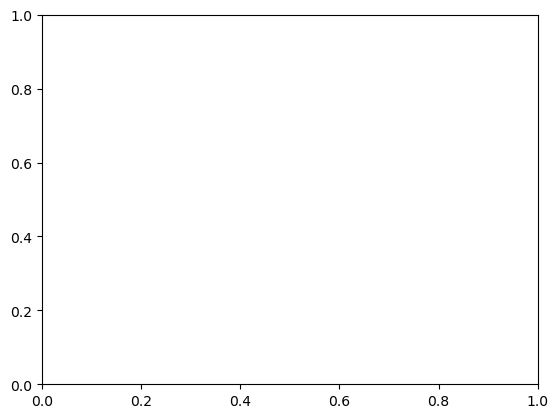

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# generate the image, i.e. plot
x = dbz[:,0]
y = dbz[0,:]
im = ax.pcolormesh(dbz[:,0], dbz[0,:], dbz)
# add a color bar
fig.colorbar(im, ax=ax)

In [7]:
dates = num2date(time[:], time.units)
time_of_day = dates[0].strftime("%Y-%m-%d %H:%M:%S")
print(time_of_day)

2015-06-26 23:00:12


In [15]:
dbz = f1.variables["DBZ"]
dbz_dimensions = f1.variables["DBZ"].dimensions
print(dbz_dimensions)
print(dbz[0,18,10,10])
type(dbz)
print(f1.variables.keys())
print(dbz)
print(len(lats), len(lons))

NameError: name 'f1' is not defined

In [11]:
print(lats[0], lons[0])

29.984999 -110.015015


In [ ]:
center = (lats[0], lons[0])



m = Map(basemap=basemaps.CartoDB.Positron, center=center, zoom=10)

marker = Marker(location=center, draggable=True)
m.add(marker);

polysize_x = abs(lats[15] - lats[14]) / 0.5
polysize_y = abs(lons[15] - lons[14]) / 0.5
for ix in range(10, 30, 3):
    for iy in range(10,30, 3):
        x = lats[ix]
        y = lons[iy]
        polygon = Polygon(
            locations=[(x, y), (x+polysize_x, y), (x, y-polysize_y)],
            color="green",
            fill_color="green"
        )
        m.add(polygon);

# color scale using a choropleth layer?
layer = ipyleaflet.Choropleth(
    geo_data=geo_json_data,
    choro_data=unemployment,
    colormap=linear.YlOrRd_04,
    border_color='black',
    style={'fillOpacity': 0.8, 'dashArray': '5, 5'})

m = ipyleaflet.Map(center = (43,-100), zoom = 4)
m.add(layer)


display(m)

In [2]:
import ipywidgets as widgets
w = widgets.IntSlider()
display(w)

IntSlider(value=0)

In [3]:
w.value

17

In [4]:
w.value = 8

In [5]:
w.keys

['_dom_classes',
 '_model_module',
 '_model_module_version',
 '_model_name',
 '_view_count',
 '_view_module',
 '_view_module_version',
 '_view_name',
 'behavior',
 'continuous_update',
 'description',
 'description_allow_html',
 'disabled',
 'layout',
 'max',
 'min',
 'orientation',
 'readout',
 'readout_format',
 'step',
 'style',
 'tabbable',
 'tooltip',
 'value']

In [6]:
a = widgets.FloatText()
b = widgets.FloatSlider()
display(a,b)
# link the callbacks and events on the browser side with jslink
mylink = widgets.jslink((a, 'value'), (b, 'value'))

FloatText(value=0.0)

FloatSlider(value=0.0)

In [ ]:
# link a widget and the map